In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import BasicAer
from qiskit.transpiler import PassManager
from qiskit.aqua import Operator, QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import L_BFGS_B, COBYLA,SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PyQuanteDriver, UnitsType, BasisType, HFMethodType

aqua_globals.random_seed = 50

In [37]:
def VQE_calcualting(input_molecule,distance):
    
    
    if input_molecule == "H2":
        driver = PyQuanteDriver(atoms = "H 0.0 0.0 0.0; H 0.0 0.0 {}".format(distance),units = UnitsType.ANGSTROM,
                            charge= 0, multiplicity=1,hf_method=HFMethodType.RHF, basis=BasisType.B631G)
    else:
        raise ValueError("Unidentified molecule")
        
    #
    molecule = driver.run()
    nuclear_repulsion=molecule.nuclear_repulsion_energy
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp_bk = ferOp.mapping(map_type='JORDAN_WIGNER', threshold=0.00000001)
    # chop is some form tolerance ??
    qubitOp_bk.chop(10**-10) 
    print("Processing: {:.2f} Angstrom".format(distance),end='\r')
    
    # Exact solver
    exact_eigensolver = ExactEigensolver(qubitOp_bk, k=1)
    result_exact = exact_eigensolver.run()
    
    # VQE part
    
    #classical optimization
    lbfgs = L_BFGS_B(maxfun=1000, factr=10, iprint=10)
    cobyla=COBYLA(maxiter=1000)
    spsa=SPSA(max_trials=1000)
    
    #variational form     
    var_form = RY(qubitOp_bk.num_qubits, 5, entanglement='full')
    
    # parameters for VQE are hamiltonian, ansatz and classical optimizer
    vqe_algorithm = VQE(qubitOp_bk, var_form, lbfgs)
    vqe_algorithm2 = VQE(qubitOp_bk, var_form, cobyla)
    vqe_algorithm3 = VQE(qubitOp_bk, var_form, spsa)
    
    #call backend
    backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend, pass_manager=PassManager())
    #running VQE function
    result_vqe = vqe_algorithm.run(quantum_instance)
    result_vqe2 = vqe_algorithm2.run(quantum_instance)
    result_vqe3 = vqe_algorithm3.run(quantum_instance)
    #return results
    return result_exact["energy"],result_vqe['eigvals'][0],result_vqe2['eigvals'][0],result_vqe3['eigvals'][0],nuclear_repulsion

In [38]:
def potential_curve_VQE(input_molecule,begin_distance,end_distance):
    
    
    #vectorification for graphing
    bond_distance = np.arange(begin_distance,end_distance+0.1 ,0.1)
    energy_exact = np.zeros(len(bond_distance))
    energy_VQE = np.zeros(len(bond_distance))
    energy_VQE2=np.zeros(len(bond_distance))
    energy_VQE3=np.zeros(len(bond_distance))
    nuclear=np.zeros(len(bond_distance))
    
    # graphing energy over r 
    for i,dis in enumerate(bond_distance):
        results = VQE_calcualting(input_molecule,dis)
        energy_exact[i] = results[0]
        energy_VQE[i]   = results[1]
        energy_VQE2[i]  = results[2]
        energy_VQE2[i]  = results[3]
        nuclear[i]= results[4]
    # plt.plot 
    plt.plot(bond_distance, energy_exact+nuclear, label="Exact Ground state energy")
    plt.plot(bond_distance, energy_VQE+nuclear,   label="VQE lbfgs")
    plt.plot(bond_distance, energy_VQE2+nuclear,   label="VQE cobyla")
    plt.plot(bond_distance, energy_VQE3+nuclear,   label="VQE spsa")
    plt.title("The ground state of {}".format(input_molecule))
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy (Hatree)')
    plt.legend()
    plt.show()  

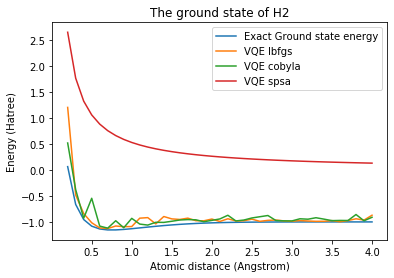

In [40]:
begin_distance = 0.2 # ANGSTROM
end_distance   = 4.0   # ANGSTROM
input_molecule = "H2"


potential_curve_VQE(input_molecule,begin_distance,end_distance)

In [10]:
?COBYLA

Object `.nuclear_repulsion_energy` not found.


In [43]:
?RY

In [35]:
?SPSA